In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [18]:
img_l = np.asanyarray(Image.open("hangerL-small.png").convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("hangerR-small.png").convert("RGB")).astype(np.int)

## Params definition

In [19]:
kg_max=40
kv_max=80

kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [20]:
#import shelve

In [21]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [22]:
#np.save("img_shift.npy", img_shift2)

In [23]:
img_shift2 = np.load("../lab1/img_shift.npy")

In [24]:
from scipy import ndimage

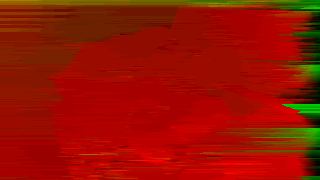

In [25]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
Image.fromarray((255*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [26]:
from random import choices
from scipy.linalg import null_space

In [28]:
def is_smooth(img_shift, x, y, radius=2):
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if np.any(img_shift[y, x] != img_shift[y+i, x+j]):
                return False
    return True


map2draw = np.zeros((img_r.shape), dtype=np.uint8)

pairs = []
rejected_pairs = []
# (X, X')
for y_r in range(30, img_r.shape[0] - 30):
    for x_r in range(30, img_r.shape[1] - 30):
        x_r3d = [x_r - img_r.shape[1]//2, y_r - img_r.shape[0]//2, 1]
        
        dot_shift = img_shift2[y_r, x_r]
        
        x_l = int(x_r + dot_shift[0])
        y_l = int(y_r - (kv_half - dot_shift[1] ))
        x_l3d = [x_l - img_r.shape[1]//2, y_l - img_r.shape[0]//2, 1]
        
        if is_smooth(img_shift2, x_r, y_r):
            pairs.append([x_l3d, x_r3d])
            map2draw[y_r, x_r] = 255
        else:
            rejected_pairs.append([x_l3d, x_r3d])

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

## Перевірка правильності пар точок

In [31]:
a = []
for r, l in zip(all_right, all_left):
    a.append(np.sum(np.abs(img_l[l[1]+img_r.shape[0]//2, l[0]+img_r.shape[1]//2] - img_r[r[1]+img_r.shape[0]//2, r[0]+img_r.shape[1]//2])))
print(sum(a)/len(a))

147.4502450980392


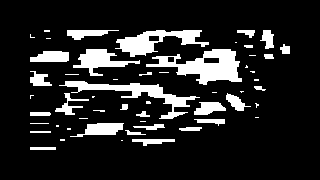

In [32]:
Image.fromarray(map2draw)

In [33]:
len(pairs)

8160

In [34]:
len(rejected_pairs)

23040

In [35]:
Boundary = 1e-6
bestF = None
bestScore = 0

all_right = np.array([i[1] for i in pairs])
all_left = np.array([i[0] for i in pairs])

for iteration in range(5000):
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for left, right in seven_pairs:
        x_l, y_l, z_l = left
        x_r, y_r, z_r = right
        X_big.append([x_r*x_l, x_r*y_l, x_r*z_l,
                      y_r*x_l, y_r*y_l, y_r*z_l,
                      z_r*x_l, z_r*y_l, z_r*z_l])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([
     np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f1),
    # на попередній лінії була помилка,
    # через яку я декілька місяців не міг зрозуміти чого не працює.
    # вічна пам'ять моїм загиблим нервовим клітинам.
    # F
    ])
    coefs = np.roots(p)
    for i in coefs:
        if np.iscomplex(i):
            continue
        F = f1+float(i)*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', all_right, F, all_left)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            print(epipole)
            #epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


hit 0.000857843137254902
[[-0.09390917  0.99541394]
 [-0.99502048 -0.09445466]
 [ 0.03339632 -0.01514619]]
X: -0.09390916978764356
Y: -0.9950204790174446
hit 0.000980392156862745
[[-7.31888090e-01]
 [ 6.81424840e-01]
 [-1.07343215e-04]]
X: -0.7318880897595278
Y: 0.6814248399827995
hit 0.33137254901960783
[[ 0.67952089]
 [-0.73179172]
 [-0.05227084]]
X: 0.6795208855362588
Y: -0.7317917228849078
hit 0.33174019607843136
[[ 0.19569842]
 [ 0.97849211]
 [-0.06523281]]
X: 0.1956984219135909
Y: 0.9784921095806594
hit 0.3324754901960784
[[ 0.55509516 -0.83155071]
 [-0.83162856 -0.55436714]
 [ 0.01622678  0.03464795]]
X: 0.5550951551564137
Y: -0.8316285591731861
hit 0.5393382352941176
[[-7.07106781e-01]
 [ 7.07106781e-01]
 [ 1.23345778e-13]]
X: -0.7071067811866942
Y: 0.7071067811864008


## Фундаментальна матриця

In [36]:
np.round(bestF, 2)

array([[  0.  ,  -0.  ,   1.17],
       [  0.  ,  -0.  ,   1.17],
       [ -1.17,  -1.17, -29.28]])

In [37]:
bestF

array([[ 1.13271344e-15, -2.03271427e-13,  1.17116318e+00],
       [ 2.01700635e-13, -2.70410864e-15,  1.17116318e+00],
       [-1.17116318e+00, -1.17116318e+00, -2.92790796e+01]])

In [38]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [39]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [40]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [41]:
print(round(100*bestScore/len(pairs), 2),"%")

53.93 %


## Епіполярна точка у 3-х координатах

In [42]:
epipole = null_space(bestF, 1e-3)
epipole

array([[-7.07106781e-01],
       [ 7.07106781e-01],
       [ 1.23345778e-13]])

In [43]:
epipole.reshape(3)

array([-7.07106781e-01,  7.07106781e-01,  1.23345778e-13])

In [44]:
np.linalg.det(bestF)

-8.27208719118766e-19

## Ліве зображення

In [51]:
from PIL import ImageDraw

In [52]:
image2show = Image.fromarray(img_r.astype(np.uint8))
draw = ImageDraw.Draw(image2show)

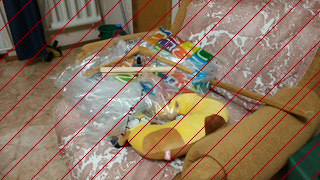

In [53]:
focus_x, focus_y = 200, 150

epipole2 = epipole.reshape(3) + np.array([200, 150, 0])

x_img = 400
for y_img in range(0, 300, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector
    
    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])


    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)

y_img = 0
for x_img in range(0, 400, 30):
    diff_vector = np.array([x_img, y_img, 1]) - epipole2.reshape(3)
    x_line1, y_line1, z_line1 = epipole2.reshape(3) + (1/3)*diff_vector
    x_line2, y_line2, z_line2 = epipole2.reshape(3) + (2/3)*diff_vector

    focus2point = np.array([x_line1, y_line1, z_line1]) - np.array([focus_x, focus_y, 0])
    projected_p1 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    focus2point = np.array([x_line2, y_line2, z_line2]) - np.array([focus_x, focus_y, 0])
    projected_p2 = np.array([focus_x, focus_y, 0]) + focus2point*(1/focus2point[-1])

    projected_diff = projected_p1 - projected_p2

    projected_p1 = projected_p1 - 1000*projected_diff
    projected_p2 = projected_p2 + 1000*projected_diff

    draw.line((*projected_p1[:-1], *projected_p2[:-1]), fill=128)
    
image2show